<a href="https://www.kaggle.com/code/rubanzasilva/s04e05-fastai?scriptVersionId=175414486" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
!pip install fastkaggle

In [3]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp

In [4]:
!ls /kaggle/input/playground-series-s4e5

sample_submission.csv  test.csv  train.csv


In [5]:
#set_seed(42)

In [6]:
path = Path('/kaggle/input/playground-series-s4e5/')
path

Path('/kaggle/input/playground-series-s4e5')

In [7]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')

In [8]:
train_df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [9]:
train_df.shape

(1117957, 21)

In [10]:
train_df.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

In [11]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

SuggestedLRs(slide=0.015848932787775993, valley=0.0008317637839354575)

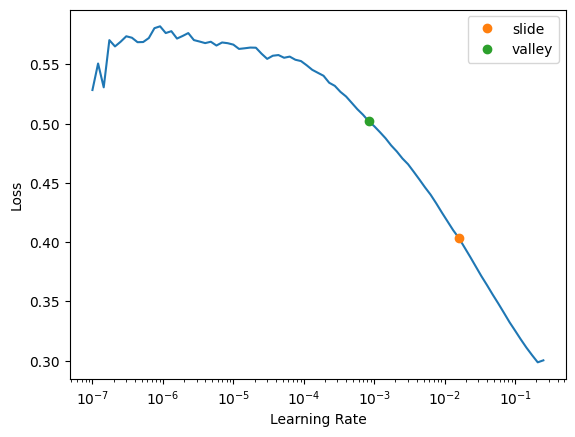

In [12]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [13]:
learn.fit_one_cycle(8,0.008)

epoch,train_loss,valid_loss,r2_score,time
0,0.000619,0.000646,0.752262,03:31
1,0.000512,0.000451,0.827187,04:01
2,0.000482,0.000428,0.835997,03:58
3,0.000489,0.000402,0.845914,03:36
4,0.000469,0.000402,0.846011,03:33
5,0.000423,0.000382,0.853485,03:41
6,0.000407,0.000371,0.857688,03:43
7,0.000414,0.000374,0.856820,03:43


In [21]:
#learn.fit_one_cycle(8,0.008)
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds
#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()


#score = R2Score(nn_preds_x,y_test)
#score


In [20]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

0.1223166

In [22]:
#with optuna params
cat_model = CatBoostRegressor(iterations=500, depth=7, learning_rate= 0.2222399612038645, random_strength=5)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

#cat_score = R2Score(y_test, cat_preds_x)
#cat_score

#mse = mean_absolute_error(y_test, cat_preds_x)
#rmse = np.sqrt(mse)
#rmse

TypeError: R2Score() takes from 0 to 1 positional arguments but 2 were given

In [ ]:
cat_score = R2Score(y_test, cat_preds_x)
cat_score

In [23]:
mse = mean_absolute_error(y_test,cat_preds_x)
rmse = np.sqrt(mse)
rmse

0.12581612

In [27]:
xgb_model = xgb.XGBRegressor(n_estimators = 187, max_depth=8, learning_rate=0.046018206875864616, subsample=0.7091172175235119)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

In [28]:
mse = mean_absolute_error(y_test, xgb_preds_x)
rmse = np.sqrt(mse)
rmse                

0.13974395

In [29]:
lgb_model = lgb.LGBMRegressor(num_leaves=47, learning_rate=0.19470589857022183, n_estimators=165)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

mse = mean_absolute_error(y_test, lgb_preds_x)
rmse = np.sqrt(mse)
rmse

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


0.12998104

In [31]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)
rmse

ValueError: Unknown label type: 'continuous'

In [33]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = nn_preds_y
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,FloodProbability,Rings
0,1117957,0.5,0.568910
1,1117958,0.5,0.454981
2,1117959,0.5,0.450971
3,1117960,0.5,0.471085
4,1117961,0.5,0.470031
...,...,...,...
745300,1863257,0.5,0.475079
745301,1863258,0.5,0.446771
745302,1863259,0.5,0.616611
745303,1863260,0.5,0.546384


In [1]:
!ls

In [35]:
general_preds = (lgb_preds + xgb_preds + cat_preds)

In [36]:
general_preds

tensor([1.7166, 1.3715, 1.3782,  ..., 1.8436, 1.6442, 1.5364])